### machine_learning_i = adaTech(program = 'LM Tech & Data Talents', module = 6)

## PROJETO FINAL

# Análise e modelagem sobre um dataset de _churn_ bancário

professores: Igor Garcia e Gilberto Kaihami

grupo 2:<br>
Adriano Gambetta <br>
Emanuelle Lemos<br>
João Pedro Bueno<br>
Manuel Castro<br>
Mike Valente<br>
Pedro Marques<br>
Raphael Morgado<br>

## ANÁLISE EXPLORATÓRIA

### imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report 
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from dtreeviz.trees import *

### carregando o dataset

Fonte: https://www.kaggle.com/datasets/shrutimechlearn/churn-modelling

In [2]:
dados = pd.read_csv('dados/Churn_Modelling.csv', sep=',')

### visão geral

Trata-se de um dataset de _churn_ bancário, ou seja, com base em uma série de características de clientes, queremos um modelo que preveja quais deles fecham suas contas, deixam de ser clientes do banco. É portanto um problema de classificação.

In [3]:
dados.columns.to_list()

['RowNumber',
 'CustomerId',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

In [4]:
dados.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


A última coluna ("Exited", com valores booleanos 0 e 1) é nosso _target_. Podemos "dropar" algumas colunas irrelevantes:

In [5]:
dados = dados.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

In [6]:
#Renomeando colunas para referenciar mais fácil

rename_columns = {
    'CreditScore' : 'cr_score',
    'Geography' : 'country',
    'Gender' : 'gender',
    'Age' : 'age',
    'Tenure' : 'tenure',
    'Balance': 'balance',
    'NumOfProducts': 'n_products',
    'HasCrCard' : 'cr_card',
    'IsActiveMember' : 'active',
    'EstimatedSalary' : 'estimated_salary',
    'Exited' : 'exited'
}

dados = dados.rename(columns=rename_columns)

In [7]:
#Não há dados nulos no dataset

dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cr_score          10000 non-null  int64  
 1   country           10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   n_products        10000 non-null  int64  
 7   cr_card           10000 non-null  int64  
 8   active            10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


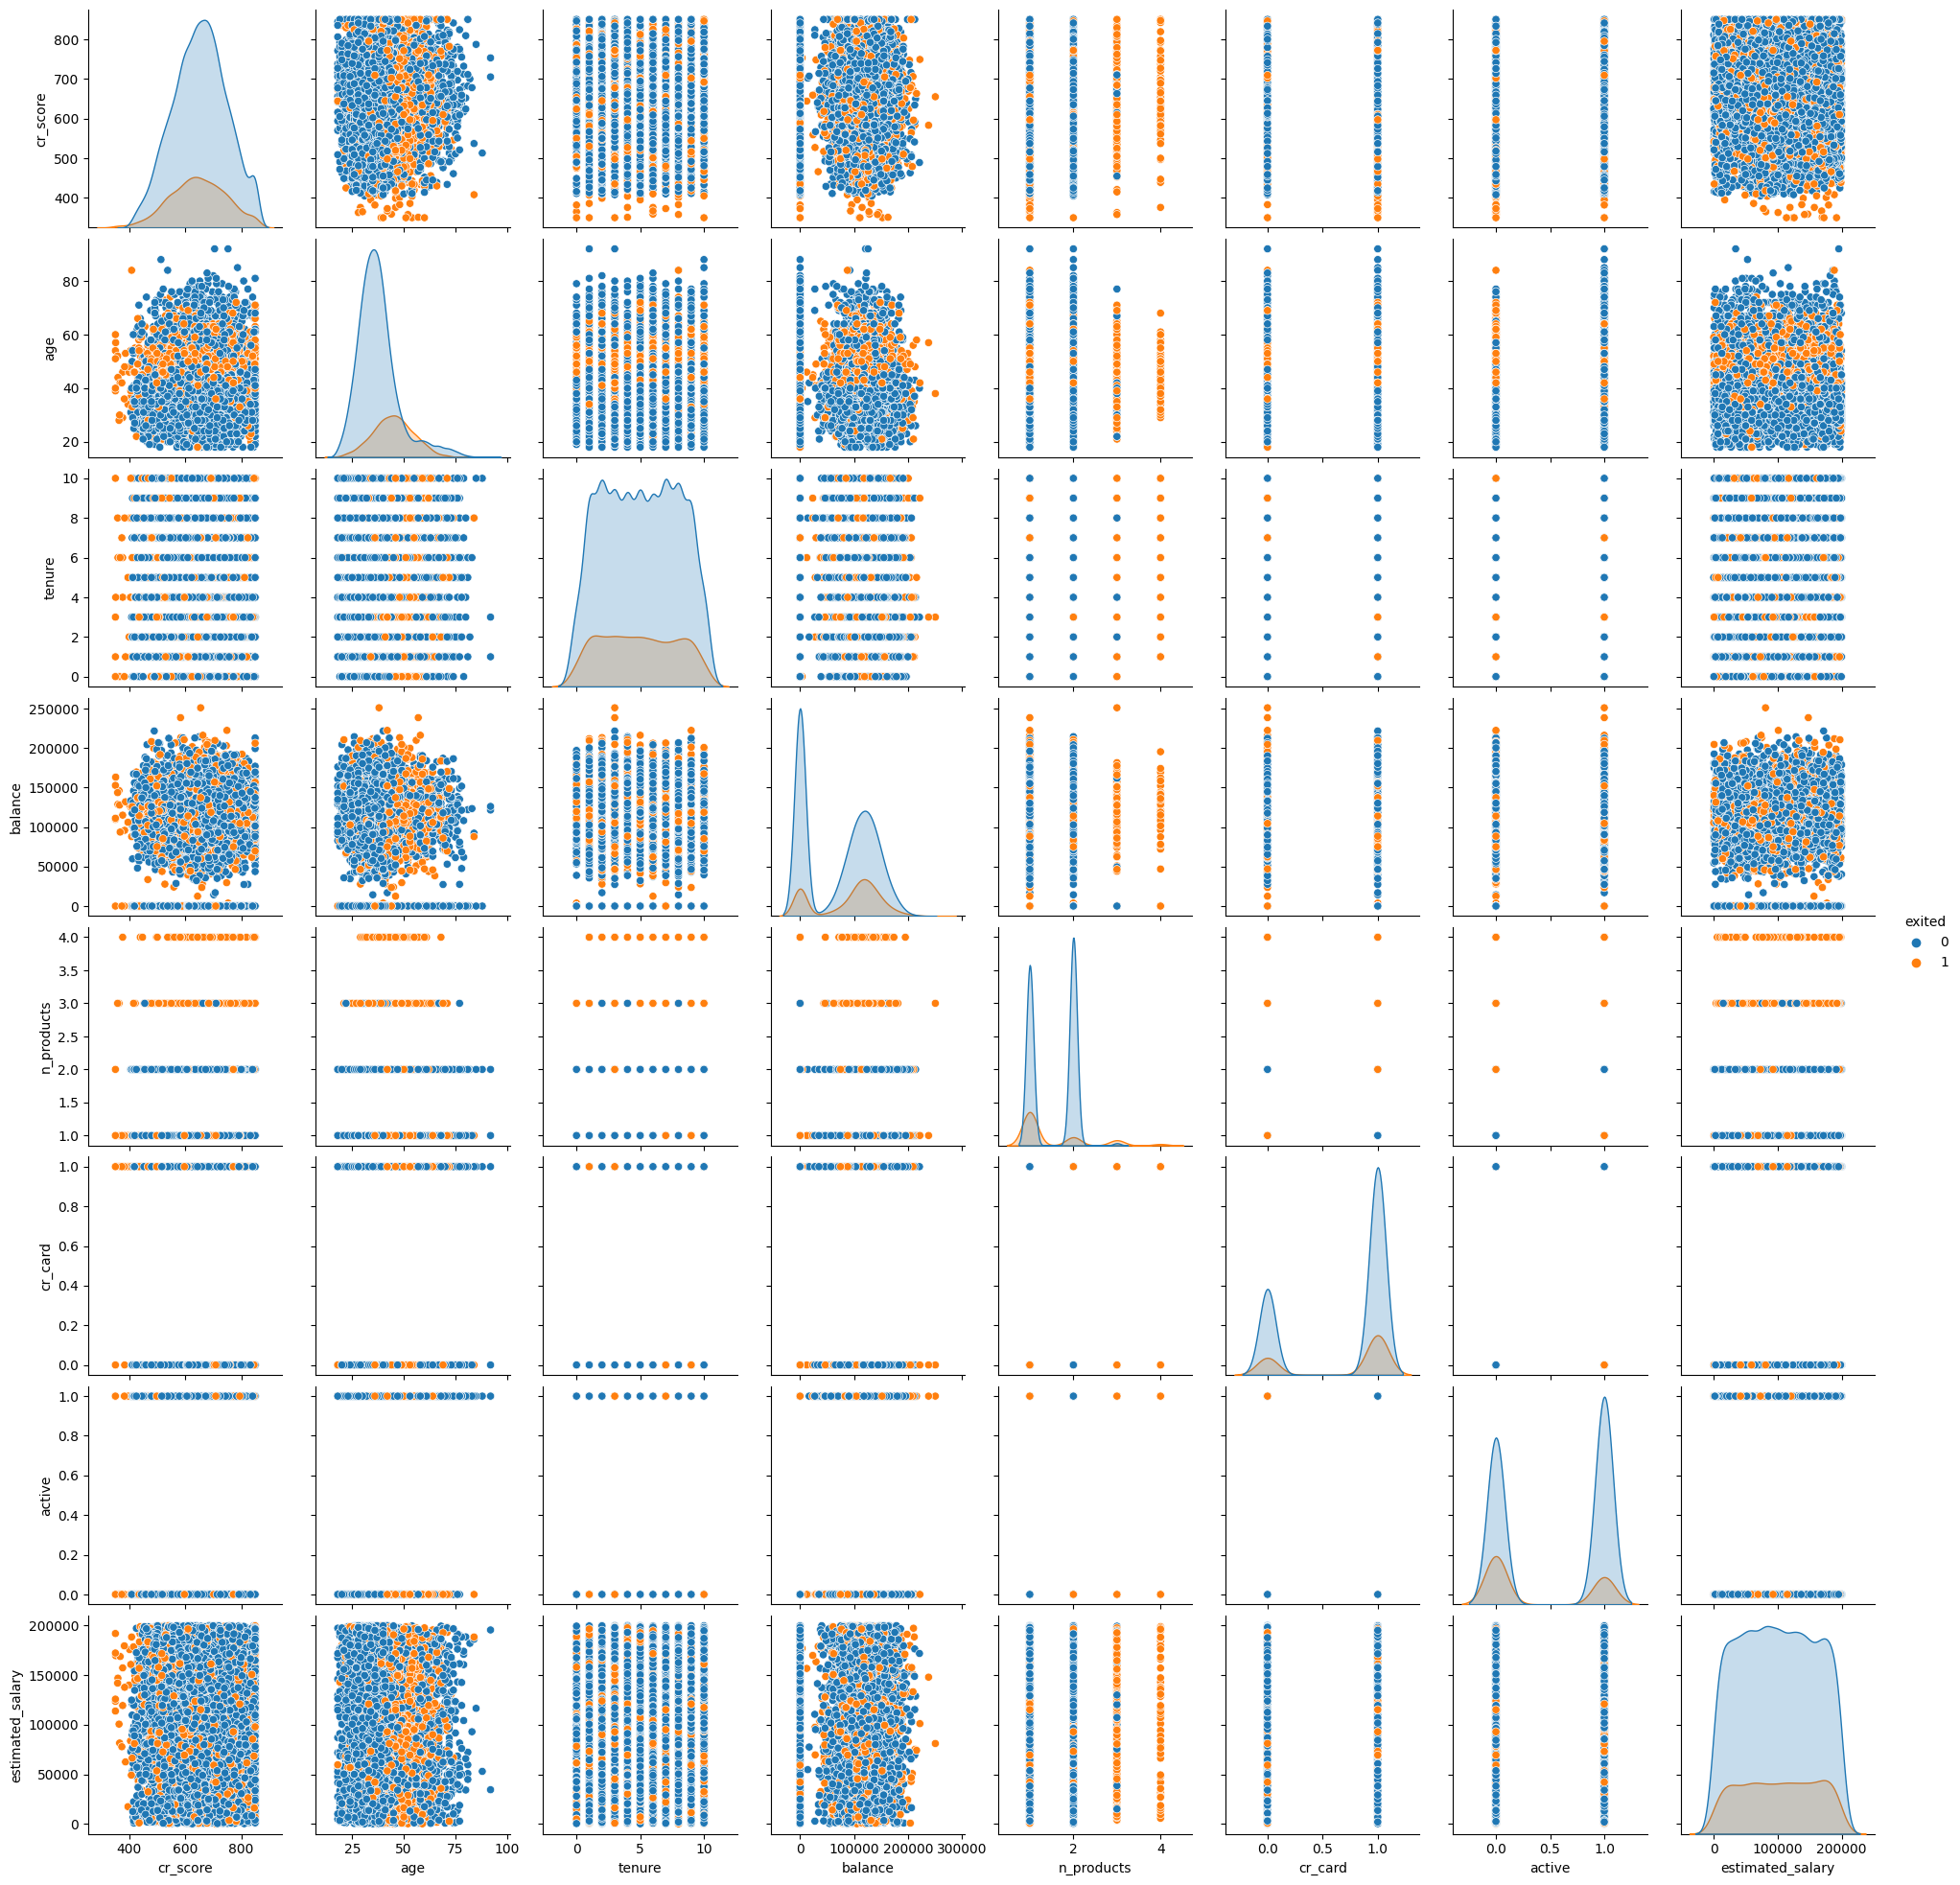

In [8]:
sns.pairplot(dados, hue='exited')
plt.show()

### estatísticas descritivas

In [9]:
#desconsiderando algumas colunas discretas/categóricas

df_descritivo = dados.drop(columns=['country', 'gender', 'n_products', 'cr_card', 'active', 'exited'])
df_descritivo.describe()

,cr_score,age,tenure,balance,estimated_salary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,100090.239881
std,96.653299,10.487806,2.892174,62397.405202,57510.492818
min,350.000000,18.000000,0.000000,0.000000,11.580000
25%,584.000000,32.000000,3.000000,0.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,199992.480000


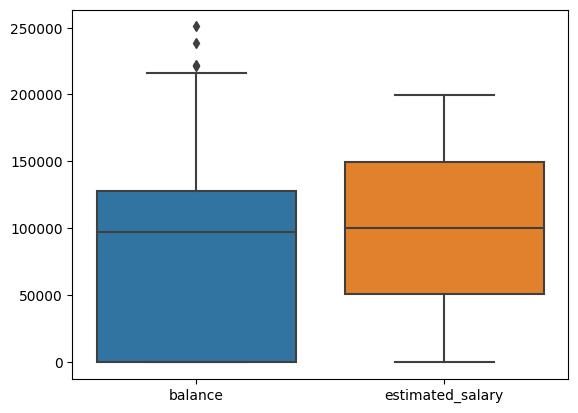

In [10]:
#Boxplot de balanço e salário. Whis ajustado para 75% do IQR para evidenciar outliers
sns.boxplot(data=dados[['balance', 'estimated_salary']], whis=0.7)
plt.show()

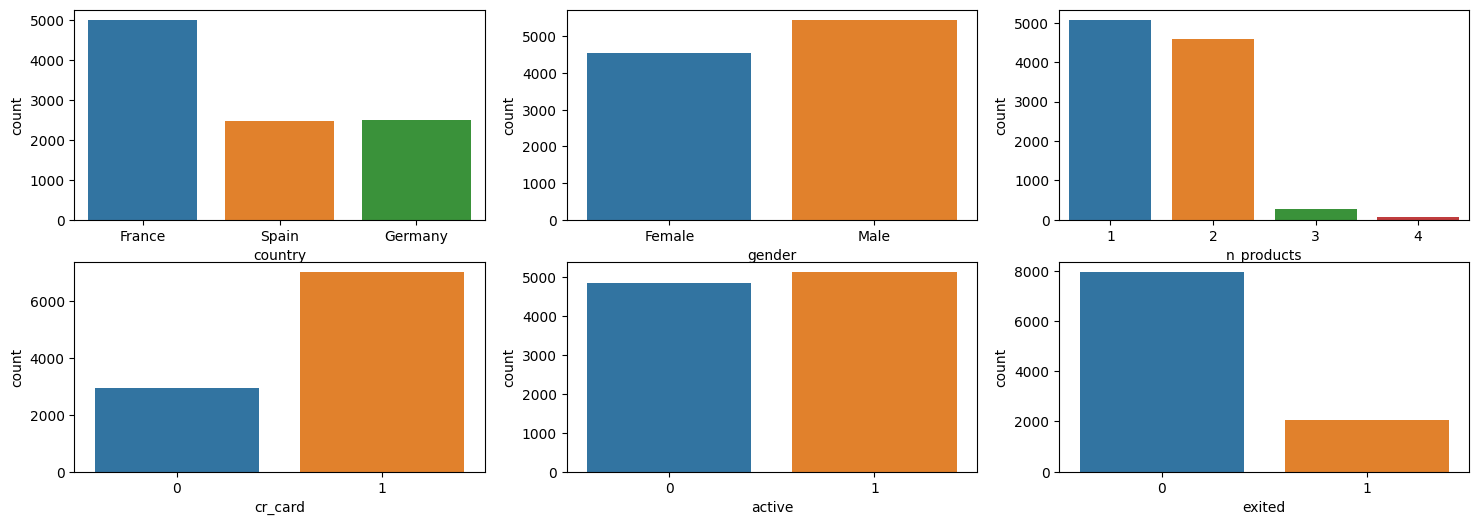

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,6))

plt.subplot(2,3,1)
sns.countplot(x='country', data=dados)

plt.subplot(2,3,2)
sns.countplot(x='gender', data=dados)

plt.subplot(2,3,3)
sns.countplot(x='n_products', data=dados)

plt.subplot(2,3,4)
sns.countplot(x='cr_card', data=dados)

plt.subplot(2,3,5)
sns.countplot(x='active', data=dados)

plt.subplot(2,3,6)
sns.countplot(x='exited', data=dados)

plt.show()

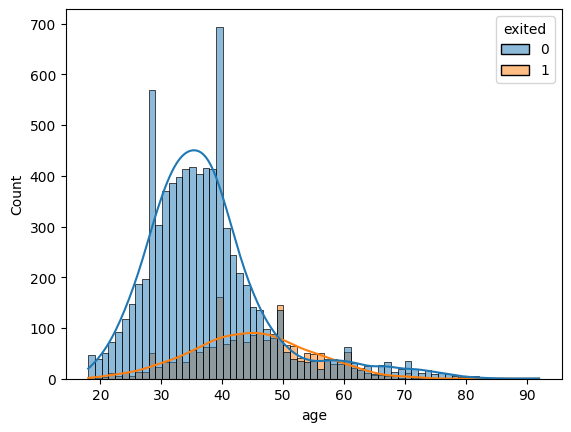

In [12]:
#Histograma com as idades dos clientes
sns.histplot(x='age', data=dados, hue='exited', kde=True)
plt.show()

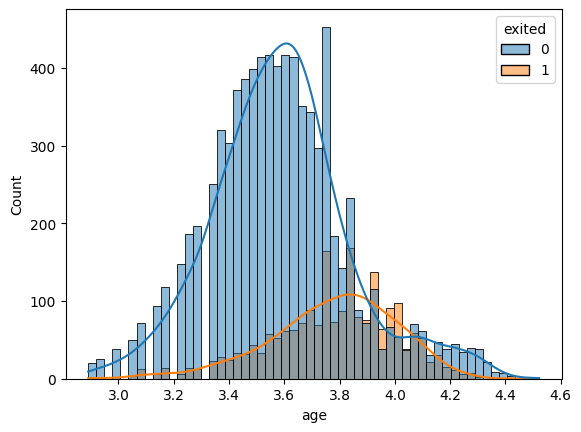

In [13]:
#A distribuição assimétrica de idades pode comprometer a performance do modelo.
#Logo, uma transformação log normal pode melhorar a capacidade de predição

dados['age'] = np.log(dados.age)

sns.histplot(x='age', data=dados, hue='exited', kde=True)
plt.show()

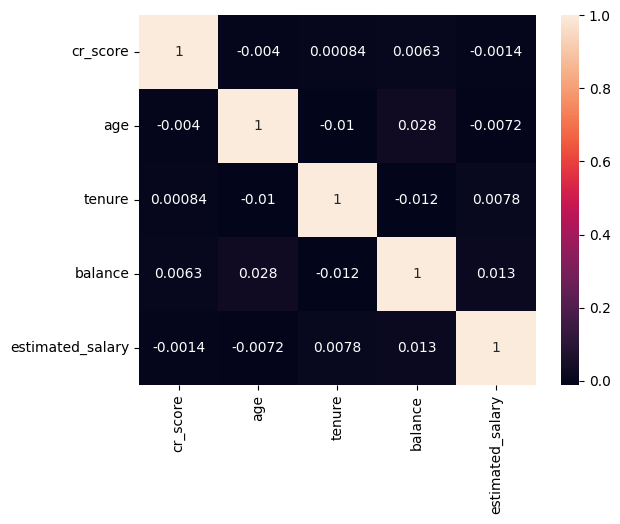

In [14]:
#Features consideradas para estatística descritiva possuem correlação fraca entre si
#Isso corrobora com a hipótese de que não há características redundantes no dataset

corr = df_descritivo.corr()

sns.heatmap(corr, annot=True)
plt.show()

### feature engineering

In [15]:
#Categorização do balanço bancário

conditions = [(dados.balance == 0), (dados.balance>0)]
values = [0, 1]
dados['acc_balance'] = np.select(conditions, values)
dados.drop(columns='balance', inplace=True)

In [16]:
#Categorização do número de produtos

conditions = [(dados.n_products==1), (dados.n_products==2), (dados.n_products>2)]
values = ['1 produto', '2 produtos', '> 2 produtos']
dados['products'] = np.select(conditions, values)
dados.drop(columns='n_products', inplace=True)

In [17]:
#Codificação de features categóricas em preparação para os modelos

df_dummies = pd.get_dummies(dados[['country', 'gender', 'products']], drop_first=True)
rename_dummies = {
    'country_Germany' : 'germany',
    'country_Spain': 'spain',
    'gender_Male': 'male',
    'products_2 produtos': '2_products',
    'products_> 2 produtos': '>2_products'
}

df_dummies = df_dummies.rename(columns=rename_dummies)

novos_dados = pd.concat([dados, df_dummies], axis=1).drop(columns=['country', 'gender', 'products'])
novos_dados = novos_dados[['cr_score','germany', 'spain', 'male', 'age', 'tenure', 'acc_balance', '2_products', '>2_products', 'cr_card', 'active', 'estimated_salary', 'exited']]
novos_dados.head()

,cr_score,germany,spain,male,age,tenure,acc_balance,2_products,>2_products,cr_card,active,estimated_salary,exited
0,619,0,0,0,3.737670,2,0,0,0,1,1,101348.88,1
1,608,0,1,0,3.713572,1,1,0,0,0,1,112542.58,0
2,502,0,0,0,3.737670,8,1,0,1,1,0,113931.57,1
3,699,0,0,0,3.663562,1,0,1,0,0,0,93826.63,0
4,850,0,1,0,3.761200,2,1,0,0,1,1,79084.10,0


In [18]:
X = novos_dados.drop(columns=['exited'])
y = novos_dados.exited
cols = X.columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=69)

scale_cols = ['cr_score', 'estimated_salary']
cat_cols = [col for col in cols if col not in scale_cols]

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[scale_cols])
X_test_scaled = scaler.transform(X_test[scale_cols])

X_train_df = pd.DataFrame(X_train_scaled, columns=scale_cols)
X_train_df = pd.concat([X_train_df, X_train[cat_cols].reset_index(drop=True)], axis=1)

X_test_df = pd.DataFrame(X_test_scaled, columns=scale_cols)
X_test_df = pd.concat([X_test_df, X_test[cat_cols].reset_index(drop=True)], axis=1)

ov = SMOTE(random_state=42)

X_train_ov, y_train_ov = ov.fit_resample(X_train_df, y_train)


undersample = RandomUnderSampler(sampling_strategy='majority',random_state=42)
X_train_un, y_train_un = undersample.fit_resample(X_train_df, y_train)

## MODELOS

Com os dados pré-processados, testamos 5 modelos de classificação: Regressão Logística, K-Nearest Neighbors, Árvore de Decisão, Random Forest e MLP (Multilayer Perceptron).

Em cada um foram feitas algumas tentativas de otimização de hiperparâmetros. De modo geral, adotamos como critério de _scoring_ para a otimização o _recall_. Isso porque o objetivo da modelagem é oferecer previsões que orientem ações no sentido da redução da taxa de _churn_. Assim, o mais importante é que nossos modelos tenham um baixo índice de **falsos negativos** (isto é, dizer que não saiu um cliente que, na realidade, saiu).

Em princípio avaliamos que os falsos positivos são menos importantes; em alguns casos, os modelos otimizados para _recall_ sacrificam precisão (e consequentemente podem ter um desempenho um pouco pior também em termos de acurácia e f1 score). Pensando no problema em questão, tal sacrifício faz sentido: redução de _churn_ tem a ver com prevenção; logo, uma taxa mais alta de falsos positivos é perfeitamente aceitável.

### Logistic Regression

In [19]:
log_reg = LogisticRegression()
log_reg.fit(X_train_ov, y_train_ov)
log_reg_predict = log_reg.predict(X_test_df)
log_reg_recall = recall_score(y_test, log_reg_predict)
print(f'recall: {log_reg_recall}')

recall: 0.7299509001636661


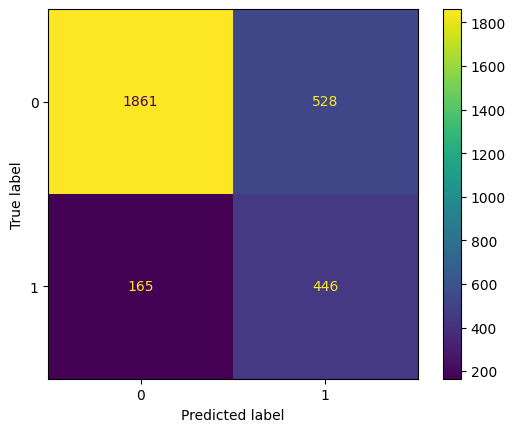

In [20]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, log_reg_predict)).plot()
plt.show()

#### Otimizando hiperparâmetros com GridSearchCV

In [21]:
np.random.seed(42)

params = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(LogisticRegression(), param_grid=params, scoring='recall', cv=5)
grid_search.fit(X_train_ov, y_train_ov)

best_params = grid_search.best_params_
best_recall = grid_search.best_score_

print('Best parameters: ', best_params)
print('Best recall: ', best_recall)

c:\Users\mike.valente\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
c:\Users\mike.valente\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
c:\Users\mike.valente\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
c:\Users\mike.valente\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
c:\Users\mike.valente\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
c:\Users\mike.valente

Best parameters:  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best recall:  0.8177324069526855


**Regressão Logística com os melhores parâmetros**

In [22]:
log_reg_best = LogisticRegression(**best_params)
log_reg_best.fit(X_train_ov, y_train_ov)
log_reg_predict = log_reg_best.predict(X_test_df)
log_reg_recall = recall_score(y_test, log_reg_predict)
log_reg_precision = precision_score(y_test, log_reg_predict)
log_reg_acc = accuracy_score(y_test, log_reg_predict)

print(f'recall: {log_reg_recall}')

recall: 0.7086743044189853


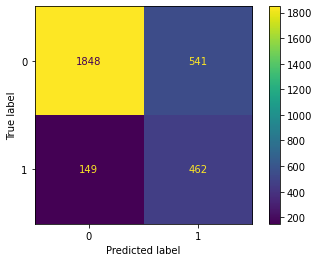

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, log_reg_predict)).plot()
plt.show()

### K-Nearest Neighbors (KNN)

KNN é um método de classificação baseado na distância entre os dados, que toma os k pontos mais próximos na distribuição e atribui ao _target_ o valor correspondente à maioria dos k votos.

              precision    recall  f1-score   support

           0       0.88      0.74      0.80      2389
           1       0.37      0.59      0.45       611

    accuracy                           0.71      3000
   macro avg       0.62      0.67      0.63      3000
weighted avg       0.77      0.71      0.73      3000



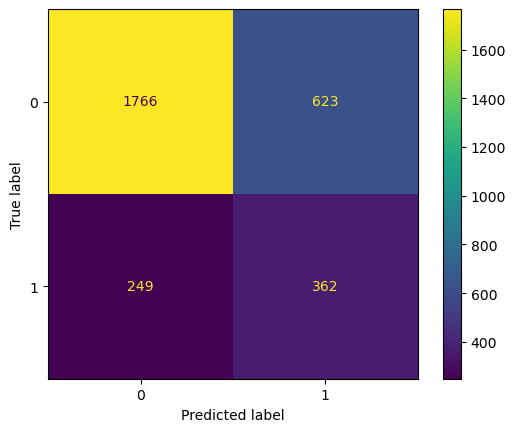

In [34]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_ov, y_train_ov)

y_pred = knn.predict(X_test_df)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

Como o único hiperparâmetro deste modelo é o número de vizinhos a ser considerado (k), podemos fazer uma otimização iterativa, avaliando o recall para cada k em um intervalo:

In [35]:
def plot_complexity_curve(
    k_list,
    knn_model,
    x_train,
    x_test,
    y_train,
    y_test
  ):
  train_scores = []
  test_scores = []

  for k in k_list:
    knn = knn_model(k)
    knn.fit(x_train, y_train)

    train_scores.append(recall_score(y_train, knn.predict(x_train)))
    test_scores.append(recall_score(y_test, knn.predict(x_test)))

  fig, ax = plt.subplots(figsize=(12, 8))
  ax.plot(k_list, train_scores, label='Training Accuracy', color='blue')
  ax.plot(k_list, test_scores, label='Test Accuracy', color='red')

  ax.set(
      title='kNN with different $k$ values',
      xlabel='Number of Neighbors',
      ylabel='Recall'
  )
  ax.legend()

  return (train_scores, test_scores)


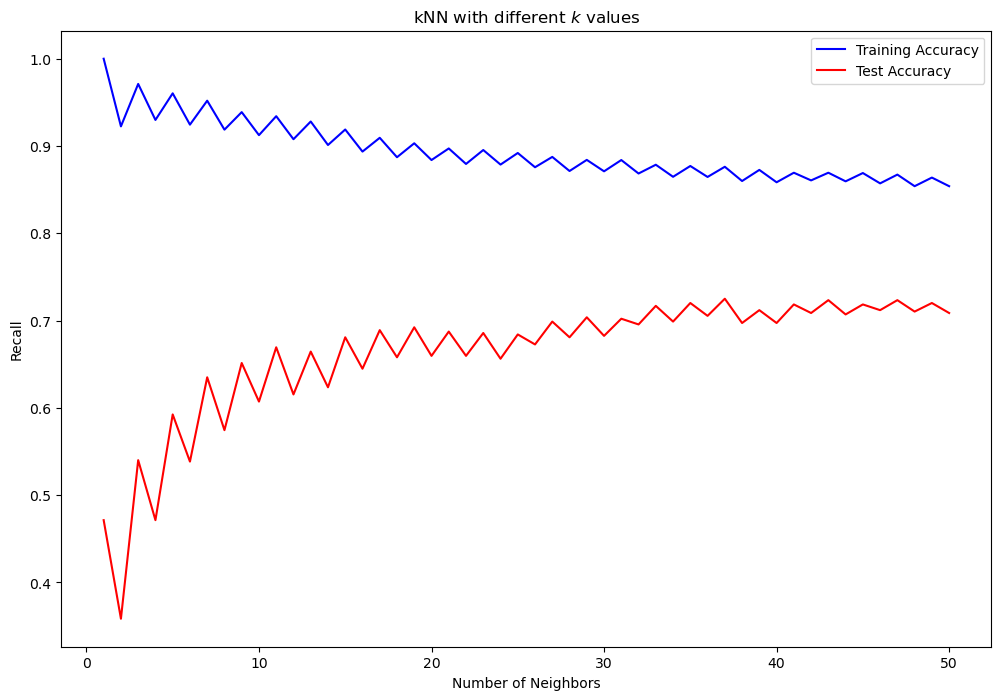

In [36]:
test_scores = plot_complexity_curve(list(np.arange(1,51)), KNeighborsClassifier, X_train_ov, X_test_df, y_train_ov, y_test)[1]

In [37]:
scores_df = pd.DataFrame({'neighbors': np.arange(1,51), 'test_score': test_scores})

scores_df[scores_df.test_score == np.max(scores_df.test_score)]

,neighbors,test_score
36,37,0.725041


              precision    recall  f1-score   support

           0       0.91      0.71      0.80      2389
           1       0.39      0.73      0.50       611

    accuracy                           0.71      3000
   macro avg       0.65      0.72      0.65      3000
weighted avg       0.80      0.71      0.74      3000



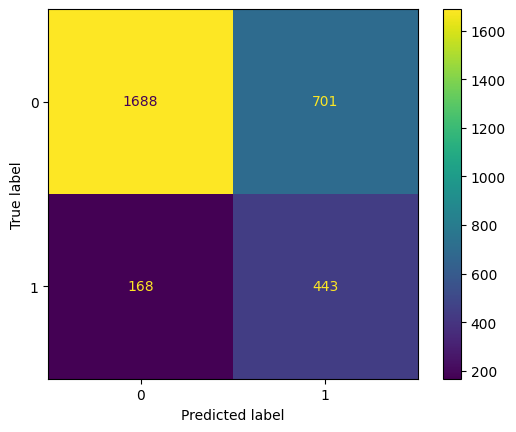

In [33]:
knn = KNeighborsClassifier(n_neighbors=37)
knn.fit(X_train_ov, y_train_ov)

y_pred = knn.predict(X_test_df)

recall_knn = recall_score(y_test, y_pred)
precision_knn = precision_score(y_test, y_pred)
acc_knn = accuracy_score(y_test, y_pred)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

### Decision Tree

In [ ]:
#usando dados após Smote
ad = DecisionTreeClassifier(random_state=42)
ad.fit(X_train_ov, y_train_ov)
predict = ad.predict(X_test_df)
recall = recall_score(y_test, predict)
print(recall)

print(confusion_matrix(y_test,predict))

print(classification_report(y_test,predict))


0.486088379705401
[[1945  444]
 [ 314  297]]
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      2389
           1       0.40      0.49      0.44       611

    accuracy                           0.75      3000
   macro avg       0.63      0.65      0.64      3000
weighted avg       0.77      0.75      0.76      3000



In [ ]:
#usando dados após Undersampling
ad = DecisionTreeClassifier(random_state=42)
ad.fit(X_train_un, y_train_un)
predict = ad.predict(X_test_df)
recall = recall_score(y_test, predict)
print(recall)

print(confusion_matrix(y_test,predict))

print(classification_report(y_test,predict))

0.7201309328968903
[[1625  764]
 [ 171  440]]
              precision    recall  f1-score   support

           0       0.90      0.68      0.78      2389
           1       0.37      0.72      0.48       611

    accuracy                           0.69      3000
   macro avg       0.64      0.70      0.63      3000
weighted avg       0.79      0.69      0.72      3000



#### Otimizando hiperparâmetros com RandomizedSearch

In [ ]:
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_split': [2, 4, 6, 8, 10, 15, 20],
    'min_samples_leaf': [1, 3, 5, 7, 9, 11, 13, 15],
    'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7,0.8,0.9,10],
    'splitter':['best','random']
}
ad = DecisionTreeClassifier(random_state=42)
# grid_search = GridSearchCV(rf, param_grid=params, scoring='recall', cv=5, verbose=3)
grid_search  = RandomizedSearchCV(ad, params, n_iter=10000, scoring='recall', cv=5, random_state=42)
grid_search.fit(X_train_un, y_train_un)

best_params = grid_search.best_params_
print('Best parameters: ', best_params)

best_recall = grid_search.score(X_test_df, y_test)
print('Best recall: ', best_recall)

Best parameters:  {'splitter': 'random', 'min_samples_split': 10, 'min_samples_leaf': 13, 'max_features': 10, 'max_depth': 50, 'criterion': 'gini'}
Best recall:  0.7774140752864157


Modelo com parâmetros otimizados

              precision    recall  f1-score   support

           0       0.93      0.74      0.83      2389
           1       0.44      0.78      0.56       611

    accuracy                           0.75      3000
   macro avg       0.68      0.76      0.69      3000
weighted avg       0.83      0.75      0.77      3000



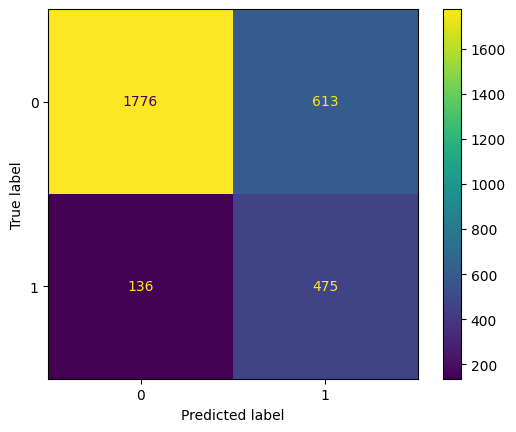

In [24]:
ad = DecisionTreeClassifier(random_state=42,splitter= 'random', min_samples_split= 10, min_samples_leaf= 13, max_features= 10, max_depth= 50, criterion= 'gini')
ad.fit(X_train_un, y_train_un)
predict = ad.predict(X_test_df)

recall_ad = recall_score(y_test, predict)
precision_ad = precision_score(y_test, predict)
acc_ad = accuracy_score(y_test, predict)

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,predict)).plot()

print(classification_report(y_test,predict))

#### Importância das features

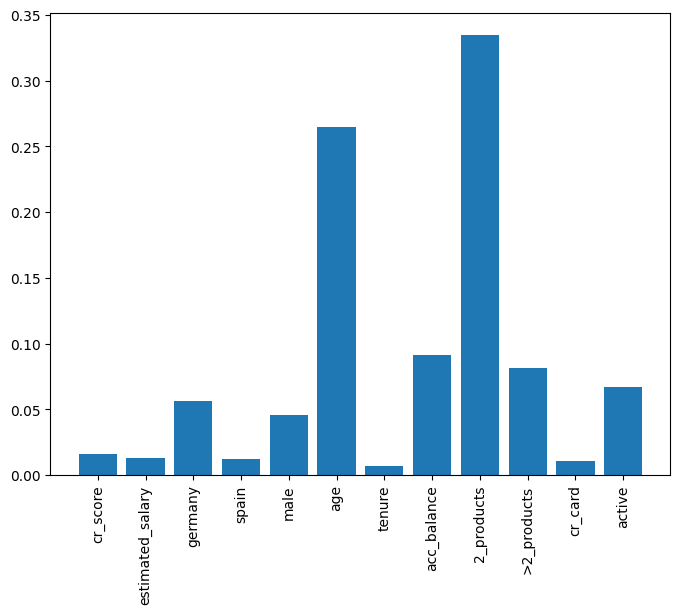

In [ ]:
fig_impor, ax_impor  = plt.subplots(figsize=(8,6))
colunas = X_test_df.columns.to_list()
import_feat = ad.feature_importances_
ax_impor.bar(colunas, import_feat)
ax_impor.tick_params(axis='x', labelrotation=90)

#### Visualização das árvores de decisão

[Text(0.5, 0.9, '2_products <= 0.16\ngini = 0.5\nsamples = 2852\nvalue = [1426, 1426]\nclass = e'),
 Text(0.25, 0.7, 'age <= 3.848\ngini = 0.46\nsamples = 1844\nvalue = [662, 1182]\nclass = x'),
 Text(0.125, 0.5, '>2_products <= 0.042\ngini = 0.496\nsamples = 1257\nvalue = [572, 685]\nclass = x'),
 Text(0.0625, 0.3, 'germany <= 0.033\ngini = 0.5\nsamples = 1140\nvalue = [566, 574]\nclass = x'),
 Text(0.03125, 0.1, '\n  (...)  \n'),
 Text(0.09375, 0.1, '\n  (...)  \n'),
 Text(0.1875, 0.3, 'cr_score <= 0.8\ngini = 0.097\nsamples = 117\nvalue = [6, 111]\nclass = x'),
 Text(0.15625, 0.1, '\n  (...)  \n'),
 Text(0.21875, 0.1, '\n  (...)  \n'),
 Text(0.375, 0.5, 'germany <= 0.691\ngini = 0.26\nsamples = 587\nvalue = [90, 497]\nclass = x'),
 Text(0.3125, 0.3, 'active <= 0.708\ngini = 0.322\nsamples = 367\nvalue = [74, 293]\nclass = x'),
 Text(0.28125, 0.1, '\n  (...)  \n'),
 Text(0.34375, 0.1, '\n  (...)  \n'),
 Text(0.4375, 0.3, 'active <= 0.092\ngini = 0.135\nsamples = 220\nvalue = [16, 204

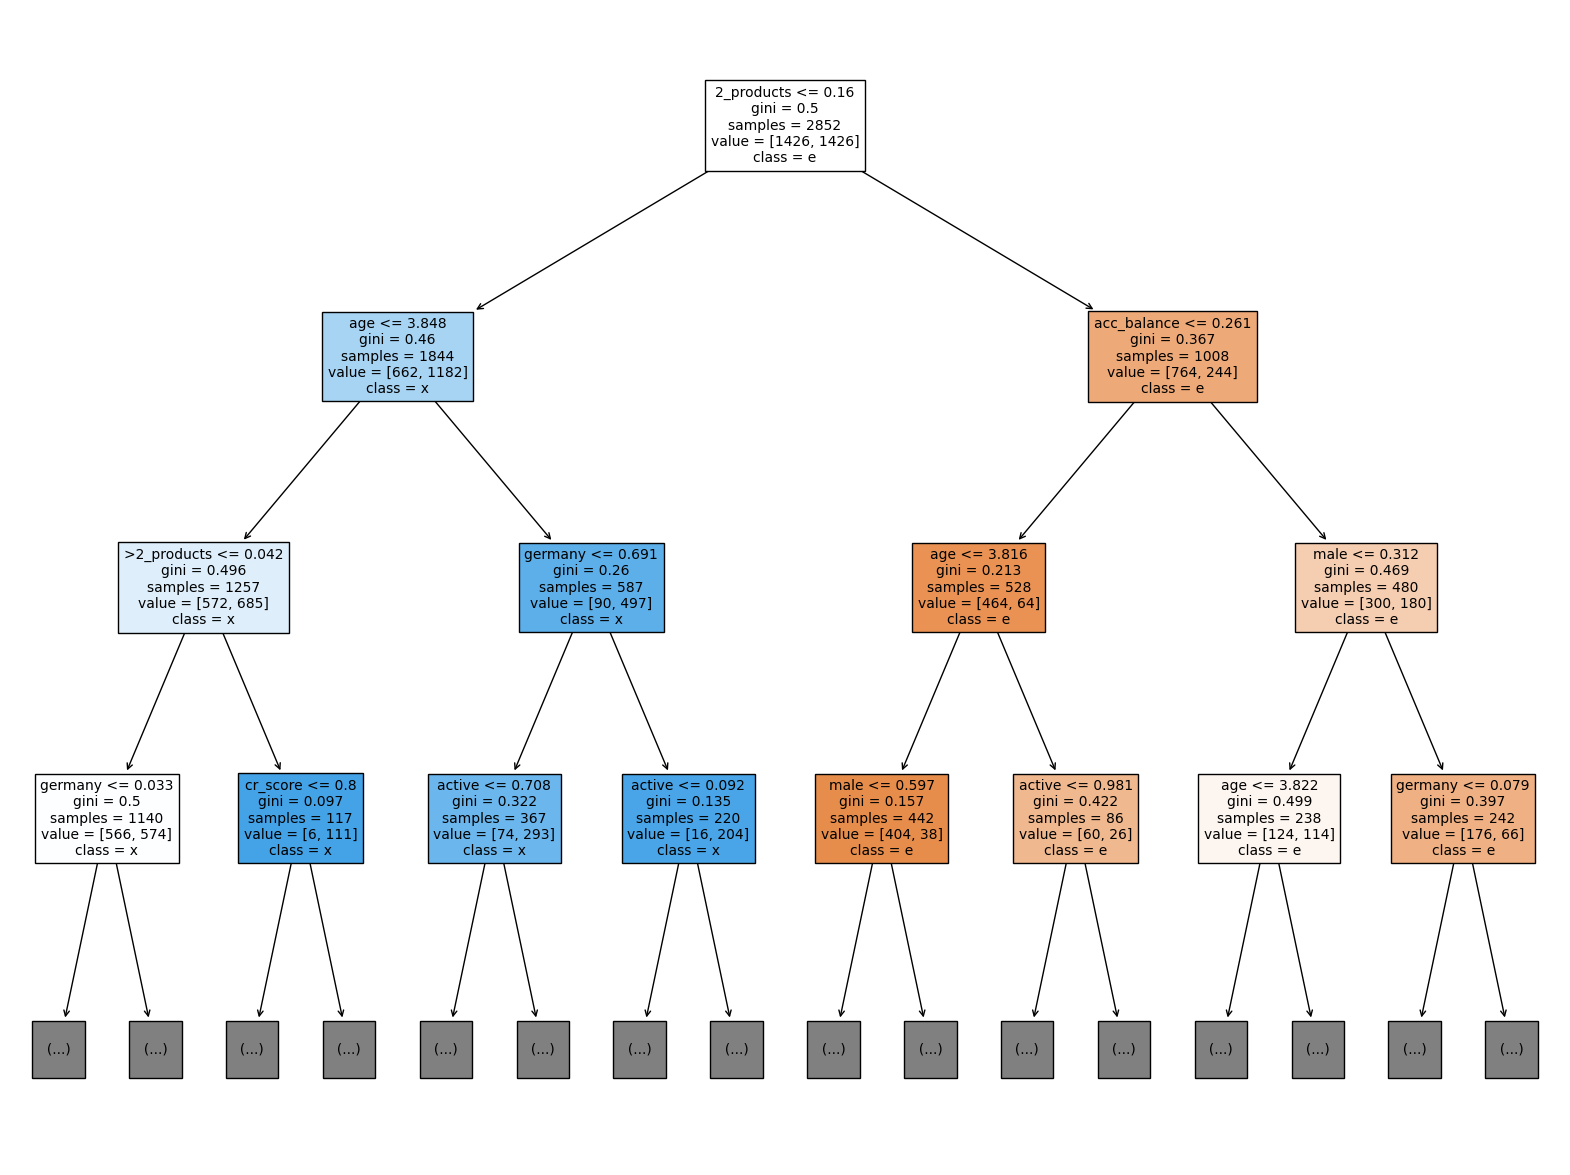

In [ ]:
fig = plt.figure(figsize=(20,15))
plot_tree(ad, 
                   feature_names=list(X_train_un.columns),
                    class_names=list(y_train_un.name),
                   filled=True,max_depth=3,fontsize=10)

### Random Forest

In [26]:
colunas_keep = [
    'cr_score',
    'estimated_salary',
    'germany',
    'male',
    'age',
    'acc_balance',
    '2_products',
    'active',
]
X_train_keep = X_train_ov[colunas_keep]
X_test_keep = X_test_df[colunas_keep]

# X_train_test = X_train_ov.copy()
# X_test_test = X_test_df.copy()

# Depois de alguns experimentos
rf = RandomForestClassifier(
    n_estimators=100,
    max_features=0.4,
    random_state=42,
    n_jobs=4,
    min_samples_leaf=50,
    max_depth=200,
    min_samples_split=10

)
rf.fit(X_train_keep, y_train_ov)
predict = rf.predict(X_test_keep)

recall_rf = recall_score(y_test, predict)
precision_rf = precision_score(y_test, predict)
acc_rf = accuracy_score(y_test, predict)

print(f'recall: {recall_rf}')

recall: 0.7103109656301145


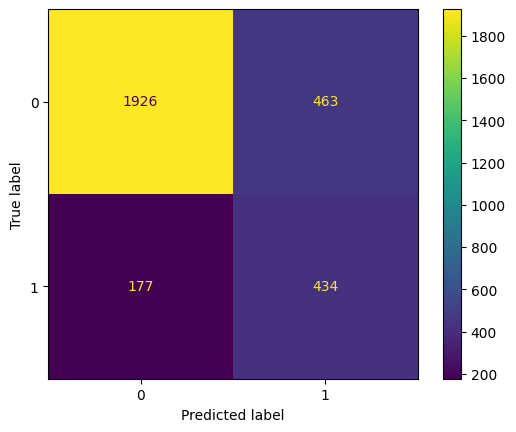

In [26]:
cm  = confusion_matrix(y_test, predict)
displ = ConfusionMatrixDisplay(confusion_matrix=cm)

displ.plot()

#### Importancia das features

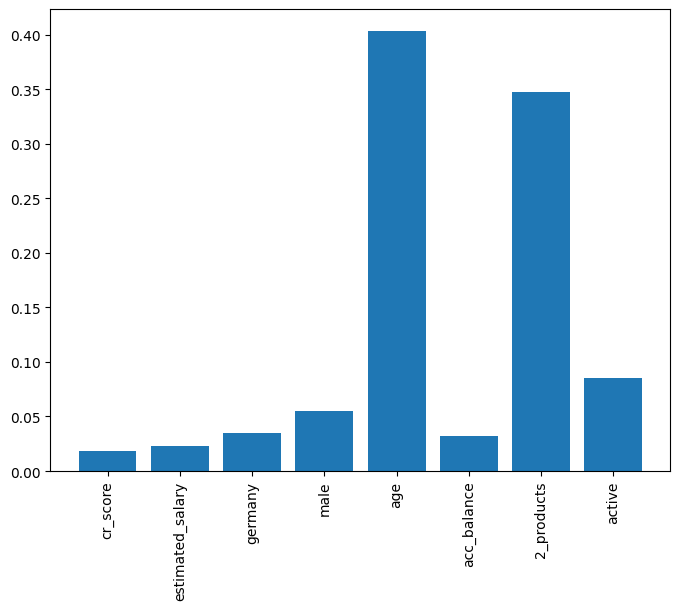

In [27]:
fig_impor, ax_impor  = plt.subplots(figsize=(8,6))
colunas = X_test_keep.columns.to_list()
import_feat = rf.feature_importances_
ax_impor.bar(colunas, import_feat)
ax_impor.tick_params(axis='x', labelrotation=90)


#### Otimizando Hiperparâmetros com RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
params = {
    'n_estimators': [500, 800, 1000, 1500, 2000, 2500, 3000],
    'criterion': ['gini', 'entropy'],
    'max_depth': [30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_split': [2, 4, 6, 8, 10, 15, 20],
    'min_samples_leaf': [1, 3, 5, 7, 9, 11, 13, 15],
    'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
}
rf = RandomForestClassifier(random_state=42)
# grid_search = GridSearchCV(rf, param_grid=params, scoring='recall', cv=5, verbose=3)
grid_search  = RandomizedSearchCV(rf, params, n_iter=100, scoring='recall', cv=5, random_state=42)
grid_search.fit(X_train_ov, y_train_ov)

best_params = grid_search.best_params_
print('Best parameters: ', best_params)

best_recall = grid_search.score(X_test_df, y_test)
print('Best recall: ', best_recall)

### MLPClassifier

In [28]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()
mlp.fit(X_train_ov, y_train_ov)
mlp_pred = mlp.predict(X_test_df)
print(classification_report(y_test, mlp_pred))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86      2389
           1       0.48      0.70      0.57       611

    accuracy                           0.79      3000
   macro avg       0.70      0.75      0.71      3000
weighted avg       0.82      0.79      0.80      3000



c:\Users\mike.valente\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


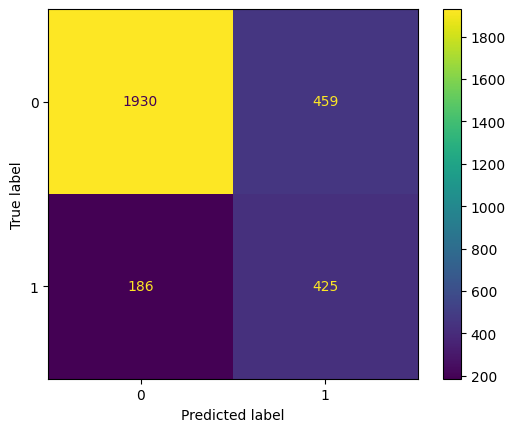

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, mlp_pred)).plot()
plt.show()

#### Otimizando Hiperparâmetros com RandomizedSearchCV

In [12]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'hidden_layer_sizes' : [100, 200, 300],
    'activation' : ['identity', 'logistic', 'tanh', 'relu'],
    'learning_rate' : ['constant', 'invscaling', 'adaptive'],
    'max_iter' : [100, 200, 300, 500]
}

random_search = RandomizedSearchCV(MLPClassifier(), params, n_iter=100, scoring='recall', cv=5, n_jobs = 3, random_state=42)
random_search.fit(X_train_ov, y_train_ov)

best_params = random_search.best_params_
print('Best parameters: ', best_params)

best_recall = random_search.score(X_test_df, y_test)
print('Best recall: ', best_recall)

Best parameters:  {'max_iter': 300, 'learning_rate': 'constant', 'hidden_layer_sizes': 100, 'activation': 'relu'}
Best recall:  0.6415711947626841


#### Otimizando Hiperparâmetros com GridSearchCV

In [13]:
def print_dataframe(filtered_cv_results):
    """Pretty print for filtered dataframe"""
    for mean_precision, std_precision, mean_recall, std_recall, params in zip(
        filtered_cv_results["mean_test_precision"],
        filtered_cv_results["std_test_precision"],
        filtered_cv_results["mean_test_recall"],
        filtered_cv_results["std_test_recall"],
        filtered_cv_results["params"],
    ):
        print(
            f"precision: {mean_precision:0.3f} (±{std_precision:0.03f}),"
            f" recall: {mean_recall:0.3f} (±{std_recall:0.03f}),"
            f" for {params}"
        )
    print()


def refit_strategy(cv_results):
    """Define the strategy to select the best estimator.

    The strategy defined here is to filter-out all results below a precision threshold
    of 0.98, rank the remaining by recall and keep all models with one standard
    deviation of the best by recall. Once these models are selected, we can select the
    fastest model to predict.

    Parameters
    ----------
    cv_results : dict of numpy (masked) ndarrays
        CV results as returned by the `GridSearchCV`.

    Returns
    -------
    best_index : int
        The index of the best estimator as it appears in `cv_results`.
    """
    # print the info about the grid-search for the different scores
    precision_threshold = 0.7

    cv_results_ = pd.DataFrame(cv_results)
    print("All grid-search results:")
    print_dataframe(cv_results_)

    # Filter-out all results below the threshold
    high_precision_cv_results = cv_results_[
        cv_results_["mean_test_precision"] > precision_threshold
    ]

    print(f"Models with a precision higher than {precision_threshold}:")
    print_dataframe(high_precision_cv_results)

    high_precision_cv_results = high_precision_cv_results[
        [
            "mean_score_time",
            "mean_test_recall",
            "std_test_recall",
            "mean_test_precision",
            "std_test_precision",
            "rank_test_recall",
            "rank_test_precision",
            "params",
        ]
    ]

    # Select the most performant models in terms of recall
    # (within 1 sigma from the best)
    best_recall_std = high_precision_cv_results["mean_test_recall"].std()
    best_recall = high_precision_cv_results["mean_test_recall"].max()
    best_recall_threshold = best_recall - best_recall_std

    high_recall_cv_results = high_precision_cv_results[
        high_precision_cv_results["mean_test_recall"] > best_recall_threshold
    ]
    print(
        "Out of the previously selected high precision models, we keep all the\n"
        "the models within one standard deviation of the highest recall model:"
    )
    print_dataframe(high_recall_cv_results)

    # From the best candidates, select the fastest model to predict
    fastest_top_recall_high_precision_index = high_recall_cv_results[
        "mean_score_time"
    ].idxmin()

    print(
        "\nThe selected final model is the fastest to predict out of the previously\n"
        "selected subset of best models based on precision and recall.\n"
        "Its scoring time is:\n\n"
        f"{high_recall_cv_results.loc[fastest_top_recall_high_precision_index]}"
    )

    return fastest_top_recall_high_precision_index

In [14]:
from sklearn.model_selection import GridSearchCV

params = {
    'hidden_layer_sizes' : [100, 200, 300, 400, 500],
    'activation' : ['identity', 'logistic', 'tanh', 'relu'],
    'learning_rate' : ['constant', 'invscaling', 'adaptive'],
    'max_iter' : [100, 200, 300, 400, 500, 600],
    'warm_start' : [True, False]
}

grid_search  = GridSearchCV(MLPClassifier(), params, n_jobs = 3, scoring=['precision', 'recall'], refit = refit_strategy)
grid_search.fit(X_train_ov, y_train_ov)


All grid-search results:
precision: 0.797 (±0.004), recall: 0.824 (±0.128), for {'activation': 'identity', 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'max_iter': 100, 'warm_start': True}
precision: 0.791 (±0.021), recall: 0.843 (±0.080), for {'activation': 'identity', 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'max_iter': 100, 'warm_start': False}
precision: 0.810 (±0.025), recall: 0.809 (±0.091), for {'activation': 'identity', 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'max_iter': 200, 'warm_start': True}
precision: 0.803 (±0.026), recall: 0.830 (±0.072), for {'activation': 'identity', 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'max_iter': 200, 'warm_start': False}
precision: 0.794 (±0.024), recall: 0.842 (±0.081), for {'activation': 'identity', 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'max_iter': 300, 'warm_start': True}
precision: 0.793 (±0.020), recall: 0.838 (±0.088), for {'activation': 'identity', 'hidden_layer_si

GridSearchCV(estimator=MLPClassifier(), n_jobs=3,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [100, 200, 300, 400, 500],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'max_iter': [100, 200, 300, 400, 500, 600],
                         'warm_start': [True, False]},
             refit=<function refit_strategy at 0x000002ABC22BFBE0>,
             scoring=['precision', 'recall'])

In [15]:
grid_best_parameters = grid_search.best_params_
print(grid_best_parameters)

{'activation': 'identity', 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'max_iter': 600, 'warm_start': False}


In [17]:
opt_pred = grid_search.predict(X_test_df)
print(recall_score(y_test, opt_pred))

0.6513911620294599


In [30]:
mlp_opt = MLPClassifier(activation = 'identity', hidden_layer_sizes = 100, learning_rate = 'adaptive', max_iter = 600, warm_start = False)

mlp_opt.fit(X_train_ov, y_train_ov)
mlp_opt_pred = mlp_opt.predict(X_test_df)

recall_mlp = recall_score(y_test, mlp_opt_pred)
precision_mlp = precision_score(y_test, mlp_opt_pred)
acc_mlp = accuracy_score(y_test, mlp_opt_pred)

print(classification_report(y_test, mlp_opt_pred))

              precision    recall  f1-score   support

           0       0.91      0.79      0.85      2389
           1       0.47      0.71      0.56       611

    accuracy                           0.78      3000
   macro avg       0.69      0.75      0.71      3000
weighted avg       0.82      0.78      0.79      3000



## CONCLUSÕES

Comparando as métricas, o modelo que conseguiu o índice mais alto de recall foi o DecisionTreeClassifier, após a otimização de hiperparâmetros com RandomizedSearch. Note-se que mesmo otimizando pelo recall, o modelo manteve um bom desempenho também nas outras métricas. Por se tratar de um modelo relativamente simples, em termos de custo computacional (bem menor que RF ou MLP) nos parece ser uma escolha recomendável.

Pela análise de feature importance vemos que as características mais decisivas são a idade e o número de produtos, sendo que os clientes que possuem exatamente 2 produtos ou mais do que 2 têm menos chances de sair. Eventuais ações de prevenção de _churn_, portanto, deveriam ser tomadas levando em consideração esse público alvo, de pessoas mais idosas e pessoas que têm menos de 2 produtos.

In [34]:
resultados=pd.DataFrame(data={'Recall':[log_reg_recall,recall_knn,recall_ad,recall_rf,recall_mlp],'Precision':[log_reg_precision,precision_knn,precision_ad,precision_rf,precision_mlp],
                   'Accuracy':[log_reg_acc,acc_knn,acc_ad,acc_rf,acc_mlp]},index=['LogisticRegression','KNN','DecisionTree','RandomForest','MLP'])
resultados.sort_values('Recall',ascending=False)

,Recall,Precision,Accuracy
DecisionTree,0.777414,0.436581,0.750333
KNN,0.725041,0.387238,0.710333
MLP,0.711948,0.465739,0.775000
RandomForest,0.710311,0.483835,0.786667
LogisticRegression,0.708674,0.433433,0.752000
